In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/twitter-entity-sentiment-analysis/twitter_validation.csv
/kaggle/input/twitter-entity-sentiment-analysis/twitter_training.csv


In [2]:
df_train = pd.read_csv('/kaggle/input/twitter-entity-sentiment-analysis/twitter_training.csv', names = ['ID', 'Platform', 'Sentiment', 'Text'])
df_test = pd.read_csv('/kaggle/input/twitter-entity-sentiment-analysis/twitter_validation.csv', names = ['ID', 'Platform', 'Sentiment', 'Text'])

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         74682 non-null  int64 
 1   Platform   74682 non-null  object
 2   Sentiment  74682 non-null  object
 3   Text       73996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


In [4]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         1000 non-null   int64 
 1   Platform   1000 non-null   object
 2   Sentiment  1000 non-null   object
 3   Text       1000 non-null   object
dtypes: int64(1), object(3)
memory usage: 31.4+ KB


## Encode the Sentiments to a Numeric value

In [5]:
from sklearn import preprocessing 

print(df_train['Sentiment'].unique())
print(df_test['Sentiment'].unique())

LE = preprocessing.LabelEncoder()
df_train['Sentiment'] = LE.fit_transform(df_train['Sentiment'])
df_test['Sentiment'] = LE.transform(df_test['Sentiment'])

print(df_train['Sentiment'][:5], df_test['Sentiment'][:5])

['Positive' 'Neutral' 'Negative' 'Irrelevant']
['Irrelevant' 'Neutral' 'Negative' 'Positive']
0    3
1    3
2    3
3    3
4    3
Name: Sentiment, dtype: int64 0    0
1    2
2    1
3    1
4    2
Name: Sentiment, dtype: int64


Creating a dataset that is simple. For this, we'll discard all the other columns and will only keep ```Sentiment``` and ```Text```

## Data Cleaning

We will be using RegEx to remove certain patterns.
*     Remove punctuation
*     Lowercase letters
*     Remove numbers
*     Remove Stop Words

We will be using the ```apply``` function of pandas to apply the above mentioned things from the text

In [6]:
!pip install nltk

In [7]:
# We are doing this step to install nltk dependencies as the interpreter can't find it so we are manually downloading it and unzipping it

import nltk
import subprocess

# Download and unzip wordnet
try:
    nltk.data.find('wordnet.zip')
except:
    nltk.download('wordnet', download_dir='/kaggle/working/')
    command = "unzip /kaggle/working/corpora/wordnet.zip -d /kaggle/working/corpora"
    subprocess.run(command.split())
    nltk.data.path.append('/kaggle/working/')

[nltk_data] Downloading package wordnet to /kaggle/working/...
Archive:  /kaggle/working/corpora/wordnet.zip
   creating: /kaggle/working/corpora/wordnet/
  inflating: /kaggle/working/corpora/wordnet/lexnames  
  inflating: /kaggle/working/corpora/wordnet/data.verb  
  inflating: /kaggle/working/corpora/wordnet/index.adv  
  inflating: /kaggle/working/corpora/wordnet/adv.exc  
  inflating: /kaggle/working/corpora/wordnet/index.verb  
  inflating: /kaggle/working/corpora/wordnet/cntlist.rev  
  inflating: /kaggle/working/corpora/wordnet/data.adj  
  inflating: /kaggle/working/corpora/wordnet/index.adj  
  inflating: /kaggle/working/corpora/wordnet/LICENSE  
  inflating: /kaggle/working/corpora/wordnet/citation.bib  
  inflating: /kaggle/working/corpora/wordnet/noun.exc  
  inflating: /kaggle/working/corpora/wordnet/verb.exc  
  inflating: /kaggle/working/corpora/wordnet/README  
  inflating: /kaggle/working/corpora/wordnet/index.sense  
  inflating: /kaggle/working/corpora/wordnet/data.

In [8]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

def preprocess_text(text):
    #lowercase
    text = str(text)
    text = text.lower()
    
    # remove punc and numbers
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    
    #tokenize text
    words = word_tokenize(text)
    
    #remove stop words
    stop_words = set(stopwords.words('english'))
    filtered_words = [word for word in words if word.lower() not in stop_words]
    
    #Lemmatization
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in filtered_words]
    
    preprocessed_text = ' '.join(lemmatized_words)
    
    return preprocessed_text

df_train['Text'] = df_train['Text'].apply(preprocess_text)
df_test['Text'] = df_test['Text'].apply(preprocess_text)


In [9]:
from sklearn.model_selection import train_test_split 
train_set = df_train[['Text', 'Sentiment']]
test_set = df_test[['Text', 'Sentiment']]

X_train, X_val, Y_train, Y_val = train_test_split(train_set['Text'], train_set['Sentiment'], test_size=.2, random_state=42)

print(f"Training Data Shape: {X_train.shape, Y_train.shape}\n"
     f"Validation Data Shape: {X_val.shape, Y_val.shape}")

Training Data Shape: ((59745,), (59745,))
Validation Data Shape: ((14937,), (14937,))


First we will tokenize the text and then do the embedding!

## Tokenize the document to feed to NN

In [10]:
## Average length of a tweet
total_words = 0
unique_words = set()
for tweet in X_train:
    tweet = str(tweet)                        ##Some of the tweets had datatype other than str so it wasn't possible to split them
    temp_list = []
    temp_list = tweet.split()
    total_words += len(temp_list)
    unique_words.update(temp_list)
        
print(f"# words in the dataset: {total_words}\n"
     f"# unique words in the dataset: {len(unique_words)}\n"
     f"Average words per tweet: {total_words//len(X_train)}")

# words in the dataset: 639762
# unique words in the dataset: 33513
Average words per tweet: 10


In [11]:
## max_tokens is set as the number of uniques words in the vocab
import tensorflow as tf
import numpy as np

X_train = np.asarray(X_train).astype(str)         #Some of the datatype had float in it so had to forcibly convert everything to STR
X_val = np.asarray(X_val).astype(str)             #Some of the datatype had float in it so had to forcibly convert everything to STR

text_vectorizer = tf.keras.layers.TextVectorization(max_tokens = 33513,
                                                    standardize = 'lower_and_strip_punctuation',
                                                    split='whitespace',
                                                    output_mode = 'int',
                                                    output_sequence_length = 10
                                                    )

text_vectorizer.adapt(X_train)
vectorized_train_text = text_vectorizer(X_train)
vectorized_val_text = text_vectorizer(X_val)

print(f"Vectorized train text shape: {vectorized_train_text.shape}\n"
     f"Vectorized val text shape: {vectorized_val_text.shape}\n")

2024-03-10 13:22:44.168215: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-10 13:22:44.168349: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-10 13:22:44.438744: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Vectorized train text shape: (59745, 10)
Vectorized val text shape: (14937, 10)



## Forming an Embedding vector out of the tokenized representation

In [12]:
## Embedding
embedding = tf.keras.layers.Embedding(input_dim = 33513,
                                      output_dim = 128
)

embedded_train_text = embedding(vectorized_train_text)
embedded_val_text = embedding(vectorized_val_text)

print(f"Embedded train text shape: {embedded_train_text.shape}\n"
     f"Embedded val text shape: {embedded_val_text.shape}\n")

Embedded train text shape: (59745, 10, 128)
Embedded val text shape: (14937, 10, 128)



## WordCould
    Wordclouds are a great way to look at the most frequent words in the document. This allows us to find other non releveant words and remove them from the vocabulary.

In [13]:
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt

# making a document from all the tweets

combined = []
for tweet in df_train.Text:
    combined.append(tweet)
    
## removing the stop words from the tweets

stop_words = set(stopwords.words('english'))
tweet_text = ' '.join(combined)
tweet_text = tweet_text.lower()
tokenized_words = word_tokenize(tweet_text)
filtered_text = [word for word in tokenized_words if word not in stop_words]
combined_text = ' '.join(filtered_text)



print(f"Length of Tweets Arrays is :{len(combined)}")
print(f"Length of Combined Tweets is :{len(combined_text)}")

Length of Tweets Arrays is :74682
Length of Combined Tweets is :5398616


(-0.5, 1599.5, 799.5, -0.5)

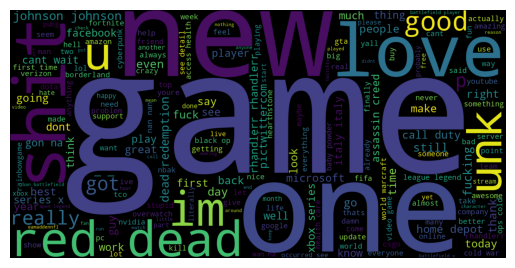

In [14]:
word_cloud = WordCloud(width = 1600, height = 800).generate(combined_text)
plt.imshow(word_cloud)
plt.axis('off')

## Baseline Model - Naive Bayes'
    Baseline model gives a starting point for further experiments. We will start with a simple Machine Learning model and will further develop on this baseline itself

In [15]:
# We will use the TF-IDF as well as the Embeddings for our experiments
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(lowercase=True)
tf_train = tfidf.fit_transform(X_train)
tf_val = tfidf.transform(X_val)

print(f"Tf-Idf train text shape: {tf_train.shape}\n"
     f"Tf-Idf val text shape: {tf_val.shape}\n")

Tf-Idf train text shape: (59745, 33474)
Tf-Idf val text shape: (14937, 33474)



In [ ]:
print(tfidf.get_feature_names_out()[:1000])

In [17]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB

gnb = GaussianNB()
val_preds = gnb.fit(tf_train.toarray(), Y_train).predict(tf_val.toarray())

## Building an Evaluation Function

    Classification quality will be measured on Precision Recall Fscore and Accuracy

In [18]:
from sklearn.metrics import precision_recall_fscore_support as prfs
from sklearn.metrics import accuracy_score 

def evaluate(true, predictions):
    lst = prfs(true, predictions, average='weighted')
    accuracy = accuracy_score(true, predictions)
    results = {'Accuracy':accuracy,
              'Precision':lst[0],
              'Recall':lst[1],
              'F Score':lst[2]}
    return results

In [19]:
baseline_results = evaluate(Y_val, val_preds)
print(baseline_results)

{'Accuracy': 0.6535448885318337, 'Precision': 0.7628256236373712, 'Recall': 0.6535448885318337, 'F Score': 0.6696804097396212}


In [20]:
# Multiomial NB

mnb = MultinomialNB()
val_preds = mnb.fit(tf_train.toarray(), Y_train).predict(tf_val.toarray())

baseline_results2 = evaluate(Y_val, val_preds)
print(baseline_results2)

{'Accuracy': 0.7109861417955413, 'Precision': 0.7507348444326549, 'Recall': 0.7109861417955413, 'F Score': 0.6991249920974022}


**Multinomial NB performs pretty well with ~71% accuracy**

## Building first DL Model

In [21]:
model1 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(10,128)),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(units=128,activation='relu'),
    tf.keras.layers.Dense(units=64,activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=4,activation='softmax')    ## No of neurons = No of classes for output in Multiclass
])

model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ global_average_pooling1d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,980 (105.39 KB)

 Trainable params: 26,980 (105.39 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
# Compiling the model

model1.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

# Fitting the model
model1.fit(x = embedded_train_text,
          y = Y_train,
          epochs = 100,
         validation_data = (embedded_val_text, Y_val))

1868/1868 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8284 - loss: 0.4286 - val_accuracy: 0.6134 - val_loss: 1.6720
Epoch 83/100
1868/1868 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8317 - loss: 0.4238 - val_accuracy: 0.6096 - val_loss: 1.6925
Epoch 84/100
1868/1868 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8324 - loss: 0.4242 - val_accuracy: 0.6090 - val_loss: 1.6776
Epoch 85/100
1868/1868 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8355 - loss: 0.4195 - val_accuracy: 0.6109 - val_loss: 1.7107
Epoch 86/100
1868/1868 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8304 - loss: 0.4265 - val_accuracy: 0.6047 - val_loss: 1.7679
Epoch 87/100
1868/1868 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8353 - loss: 0.4172 - val_accuracy: 0.6090 - val_loss: 1.6910
Epoch 88/100
1868/1868 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8336 - loss: 0.4178 - val_accuracy: 0.6103 - val_loss: 1.7586
Epoch 89/100
1868/1868 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8331 - loss: 0.4179

In [23]:
model_preds = model1.predict(embedded_val_text)
predictions1 = tf.argmax(model_preds, axis = 1) ## Getting the indices of the class with highest probability. axis=1 (implies for every row)
print(predictions1)

print(evaluate(Y_val, predictions1))

467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
tf.Tensor([0 3 1 ... 3 3 2], shape=(14937,), dtype=int64)
{'Accuracy': 0.6120372230032805, 'Precision': 0.6122972295807689, 'Recall': 0.6120372230032805, 'F Score': 0.608598098903078}


## Building a LSTM Model for further experimentation

In [24]:
model2 = tf.keras.Sequential([tf.keras.layers.Input(shape=(10, 128)),
                             tf.keras.layers.LSTM(units = 128, return_sequences=True),
                             tf.keras.layers.LSTM(units=64, return_sequences=True),
                             tf.keras.layers.LSTM(units=8),
                             tf.keras.layers.Dense(units=4, activation='softmax')])

model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 8)              │         2,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4)              │            36 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,364 (716.27 KB)

 Trainable params: 183,364 (716.27 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
model2.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer='adam',
              metrics=['accuracy'])

model2.fit(x = embedded_train_text,
          y = Y_train,
          epochs = 50,
          validation_data = (embedded_val_text, Y_val))

model2_preds = model2.predict(embedded_val_text)

1868/1868 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - accuracy: 0.8380 - loss: 0.4222 - val_accuracy: 0.6958 - val_loss: 0.8816
Epoch 22/50
1868/1868 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.8467 - loss: 0.3940 - val_accuracy: 0.7016 - val_loss: 0.8848
Epoch 23/50
1868/1868 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.8590 - loss: 0.3665 - val_accuracy: 0.7019 - val_loss: 0.9144
Epoch 24/50
1868/1868 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.8686 - loss: 0.3430 - val_accuracy: 0.7076 - val_loss: 0.9266
Epoch 25/50
1868/1868 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.8747 - loss: 0.3204 - val_accuracy: 0.7156 - val_loss: 0.9525
Epoch 26/50
1868/1868 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.8845 - loss: 0.3033 - val_accuracy: 0.7115 - val_loss: 0.9841
Epoch 27/50
1868/1868 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.8887 - loss: 0.2897 - val_accuracy: 0.7122 - val_loss: 1.0030
Epoch 28/50
1868/1868 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.8915 - loss: 0.279

In [26]:
predictions2 = tf.argmax(model2_preds, axis=1)
print(evaluate(Y_val, predictions2))

{'Accuracy': 0.7460668139519314, 'Precision': 0.7466290312099741, 'Recall': 0.7460668139519314, 'F Score': 0.7458558214602716}


## GRU RNN

In [29]:
model3 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(10, 128)),
    tf.keras.layers.GRU(units = 64, return_sequences = True),
    tf.keras.layers.GRU(units = 32),
    tf.keras.layers.Dense(4, activation='softmax')
])

model3.summary()

model3.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer = 'adam',
              metrics = ['accuracy'])

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_2 (GRU)                     │ (None, 10, 64)         │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,788 (182.77 KB)

 Trainable params: 46,788 (182.77 KB)

 Non-trainable params: 0 (0.00 B)

In [30]:
model3.fit(x = embedded_train_text,
          y = Y_train,
          epochs = 50,
          validation_data = (embedded_val_text, Y_val))

model3_preds = model3.predict(embedded_val_text)

Epoch 1/50
1868/1868 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.3462 - loss: 1.3321 - val_accuracy: 0.4171 - val_loss: 1.2671
Epoch 2/50
1868/1868 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.4271 - loss: 1.2486 - val_accuracy: 0.4362 - val_loss: 1.2341
Epoch 3/50
1868/1868 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.4448 - loss: 1.2211 - val_accuracy: 0.4398 - val_loss: 1.2345
Epoch 4/50
1868/1868 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.4626 - loss: 1.1965 - val_accuracy: 0.4748 - val_loss: 1.1810
Epoch 5/50
1868/1868 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.4828 - loss: 1.1635 - val_accuracy: 0.4758 - val_loss: 1.1735
Epoch 6/50
1868/1868 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5030 - loss: 1.1270 - val_accuracy: 0.5075 - val_loss: 1.1295
Epoch 7/50
1868/1868 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.5211 - loss: 1.0922 - val_accuracy: 0.5268 - val_loss: 1.0944
Epoch 8/50
1868/1868 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.5423 - loss: 1.0609 -

In [31]:
model3_results = tf.argmax(model3_preds, axis=1)
print(evaluate(Y_val, model3_results))

{'Accuracy': 0.7169445002343174, 'Precision': 0.7181300787655224, 'Recall': 0.7169445002343174, 'F Score': 0.7141748622860973}


## Bi-directional RNN

In [33]:
model4 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(10, 128)),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dense(units = 4, activation = 'softmax')
])

model4.summary()

model4.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer = 'adam',
              metrics = ['accuracy'])

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_3 (Bidirectional) │ (None, 10, 128)        │        74,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 10, 64)         │        31,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 32)             │        10,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 116,100 (453.52 KB)

 Trainable params: 116,100 (453.52 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model4.fit(x = embedded_train_text,
          y = Y_train,
          epochs = 50,
          validation_data = (embedded_val_text, Y_val))

model4_preds = model4.predict(embedded_val_text)

Epoch 1/50
1868/1868 ━━━━━━━━━━━━━━━━━━━━ 22s 10ms/step - accuracy: 0.3710 - loss: 1.3165 - val_accuracy: 0.4334 - val_loss: 1.2465
Epoch 2/50
1868/1868 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.4426 - loss: 1.2263 - val_accuracy: 0.4496 - val_loss: 1.2126
Epoch 3/50
1868/1868 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.4668 - loss: 1.1837 - val_accuracy: 0.4775 - val_loss: 1.1756
Epoch 4/50
1868/1868 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.4957 - loss: 1.1357 - val_accuracy: 0.4960 - val_loss: 1.1339
Epoch 5/50
  39/1868 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.5264 - loss: 1.0510

In [ ]:
model4_results = tf.argmax(model4_preds, axis=1)
print(evaluate(Y_val, model4_results))